In [1]:
from utils import *
import pandas as pd

In [8]:
depth = 3

In [18]:
def g(ell, gp, mean_ntk, data):
    try:
        gp.set_params(**{'kernel__k2__length_scale': ell})
    except:
        gp.set_params(**{'kernel__k1__k2__length_scale': ell})


    gp.fit(data[0], data[1])
    mean = gp.predict(data[2])
    
    return np.sum(mean_ntk - mean)**2

# args = (kernel, mean_ntk, data)
def optimizer(obj_func, initial_theta, bounds, args):
    save_bounds = bounds
    gp = GPR(kernel=args[0], alpha=1e-5, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)
    try:
        gp.set_params(**{'kernel__k2__length_scale': initial_theta})
        gp.set_params(**{'kernel__k2__length_scale_bounds': 'fixed'})
    except:
        gp.set_params(**{'kernel__k1__k2__length_scale': initial_theta})
        gp.set_params(**{'kernel__k1__k2__length_scale_bounds': 'fixed'})

    result = optimize.minimize_scalar(g, args=(
    gp, args[1], args[2]), 
    method='bounded', bounds=(save_bounds[:,0], save_bounds[:,1]), options={'maxiter': 10000})

    try:
        gp.set_params(**{'kernel__k2__length_scale_bounds': (save_bounds[:,0], save_bounds[:,1])})
    except:
        gp.set_params(**{'kernel__k1__k2__length_scale_bounds': (save_bounds[:,0], save_bounds[:,1])})

    theta_opt = result.x
    func_min = result.fun

    return theta_opt, func_min

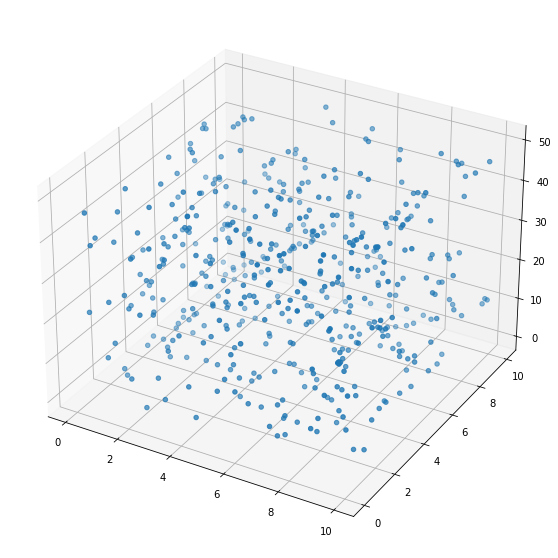

In [3]:
np.random.seed(2083)
n=500

x1 = np.random.uniform(0, 10, n)
x2 = np.random.uniform(0, 10, n)
y = np.random.uniform(0, 50, n)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,10), subplot_kw={'projection': '3d'})
ax.scatter(x1, x2, y)

In [4]:
X_train = np.stack((x1,x2), axis=-1)
y_train = y.reshape(-1,1)

In [5]:
n=500

x1 = np.random.uniform(0, 10, n)
x2 = np.random.uniform(0, 10, n)
y = np.random.uniform(0, 50, n)

X_test = np.stack((x1,x2), axis=-1)
y_test = y.reshape(-1,1)

In [6]:
X_norm_train = normalize(X_train, axis=1)
X_norm_test = normalize(X_test, axis=1)
data = [X_norm_train, y_train, X_norm_test]

In [9]:
ntk = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e5)) * 
    NTK(depth=depth, c=2, bias=0.1, 
        bias_bounds=(1e-9, 1e5))
)
gp_ntk = GPR(kernel=ntk, alpha=1e-5, normalize_y=True,  n_restarts_optimizer=9, random_state=3480795)
gp_ntk.fit(data[0], data[1])
mean_ntk = gp_ntk.predict(data[2])

const_val = gp_ntk.kernel_.get_params()['k1__constant_value']

In [21]:
lpk = (
    ConstantKernel(
        constant_value=const_val,
        constant_value_bounds='fixed'
    ) *
    Matern(
        nu=1/2,
        length_scale=1,
        length_scale_bounds=(1e-4, 1e6)
    ) 
)


gp_lpk = GPR(kernel=lpk, alpha=1e-5, normalize_y=True, optimizer=partial(optimizer, args=(lpk, mean_ntk, data)), n_restarts_optimizer=9, random_state=3480795)
gp_lpk.fit(X_train, y_train)
print(gp_lpk.kernel)

ell_lpk = optimize.minimize_scalar(g, args=(
    gp_lpk, mean_ntk, data), 
    method='bounded', bounds=[1e-4, 1e-3], options={'maxiter': 10000})
for i in range(-2, 6):
    tmp = optimize.minimize_scalar(g, args=(
        gp_lpk, mean_ntk, data),
        method='bounded', bounds=[1e-4, 10**i], options={'maxiter': 10000})
    if tmp.fun < ell_lpk.fun:
        ell_lpk = tmp

# try:
#     gp_lpk.set_params(**{'kernel__k2__length_scale': ell_lpk.x})
# except:
#     gp_lpk.set_params(**{'kernel__k1__k2__length_scale': ell_lpk.x})
# gp_lpk.fit(data[0], data[1])
# mean_lpk_opt = gp_lpk.predict(data[2])

94.6**2 * Matern(length_scale=1.84, nu=0.5)


In [10]:
gaus = (
    ConstantKernel(
        constant_value=const_val,
        constant_value_bounds='fixed'
    ) *
    Matern(
        nu=np.inf,
        length_scale=1,
        length_scale_bounds='fixed'
    ) 
)

gp_gaus = GPR(kernel=gaus, alpha=1e-5, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)

ell_gaus = optimize.minimize_scalar(g, args=(
    gp_gaus, mean_ntk, data), 
    method='bounded', bounds=[1e-4, 1e-3], options={'maxiter': 10000})
for i in range(-2, 6):
    tmp = optimize.minimize_scalar(g, args=(
        gp_gaus, mean_ntk, data),
        method='bounded', bounds=[1e-4, 10**i], options={'maxiter': 10000})
    if tmp.fun < ell_gaus.fun:
        ell_gaus = tmp

try:
    gp_gaus.set_params(**{'kernel__k2__length_scale': ell_gaus.x})
except:
    gp_gaus.set_params(**{'kernel__k1__k2__length_scale': ell_gaus.x})
gp_gaus.fit(data[0], data[1])
mean_gaus_opt = gp_gaus.predict(data[2])

In [11]:
ell_lpk

     fun: 4.251854946334346e-15
 message: 'Solution found.'
    nfev: 33
  status: 0
 success: True
       x: 1.836299162848967

In [12]:
ell_gaus

     fun: 0.00019418427157555742
 message: 'Solution found.'
    nfev: 32
  status: 0
 success: True
       x: 164.9797994703705

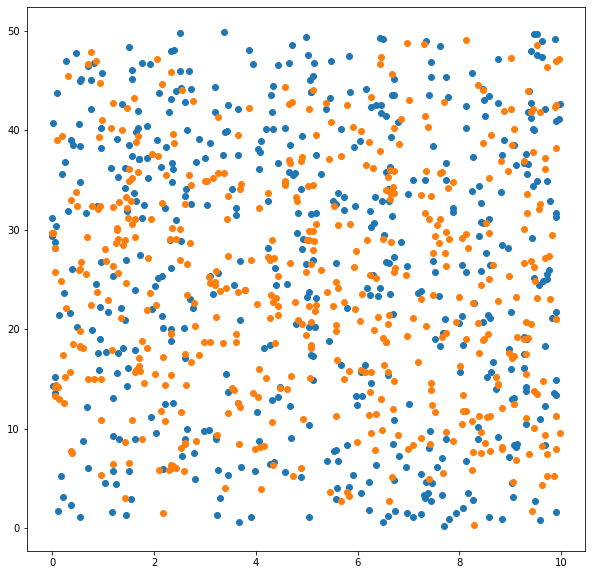

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
ax.scatter(x1, y)
# ax.scatter(x1, mean_ntk)
ax.scatter(x1, mean_lpk_opt)
# ax.scatter(x1, mean_gaus_opt)

In [22]:
x = np.random.randn(5).reshape(-1,1)
y = np.random.randn(5).reshape(-1,1)

In [23]:
x.shape

(5, 1)

In [24]:
ntk(x.T,y.T)

array([[0.90200436]])

In [25]:
lpk(x.T, y.T)

array([[2083.93420982]])